##### Library import

In [74]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler

In [75]:
df = pd.read_csv('../data/clean/processed_data.csv')
tscv = TimeSeriesSplit(n_splits=10)
scaler = StandardScaler()

##### Linear Regression

In [93]:
df_lr = df.copy()
y = df_lr['energy_demand']
X = df_lr
X['date'] = pd.to_datetime(X['date'])
X['month'] = X['date'].dt.month
X['day'] = X['date'].dt.day
X['hour'] = X['date'].dt.hour
X = X.drop(['energy_demand', 'date', 'is_weekend_False', 'atmospheric_pressure_sea_level'], axis = 1).astype(float)
metrics_lr = []
total_train_time = 0
total_test_time = 0

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = sm.add_constant(X_train, has_constant='add')
    X_test = sm.add_constant(X_test, has_constant='add')
    
    start_train = time.time()
    model = sm.OLS(y_train, X_train).fit()
    total_train_time += (time.time() - start_train)

    start_test = time.time()
    y_pred = model.predict(X_test)
    total_test_time += (time.time() - start_test)
    
    metrics_lr.append({
        'RMSE': root_mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred)
    })

df_lr = pd.DataFrame(metrics_lr).mean()
print(model.summary())
print(f"Tempo médio de treinamento: {total_train_time/10:.4f}s")
print(f"Tempo médio de inferencia: {total_inference_time/10:.4f}s")
df_lr

                            OLS Regression Results                            
Dep. Variable:          energy_demand   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                 2.301e+04
Date:                Sat, 14 Feb 2026   Prob (F-statistic):               0.00
Time:                        19:22:55   Log-Likelihood:            -1.3402e+05
No. Observations:               15950   AIC:                         2.681e+05
Df Residuals:                   15927   BIC:                         2.683e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -2239.54

RMSE    1528.659263
MAE     1227.245676
MAPE       0.029296
dtype: float64

In [84]:
vif = pd.DataFrame()
vif['variable'] = X.columns
vif['VIF'] = [
    variance_inflation_factor(X.values, i)
    for i in range(X.shape[1])
]

vif.sort_values('VIF', ascending=False)

,variable,VIF
0,atmospheric_pressure_sea_level,2738.000133
2,air_temp_dry_bulb,1671.429711
4,relative_humidity,1541.586683
3,dew_point_temp,950.089209
11,lag_24h,347.802815
8,lag_1h,303.873666
12,lag_48h,208.502291
10,lag_12h,165.410418
9,lag_6h,146.670338
14,lag_192h,133.741491


##### SARIMAX

In [17]:
adf = adfuller(df['energy_demand'])
print(f'p-values: {adf[1]}')

p-values: 6.471378478801788e-21


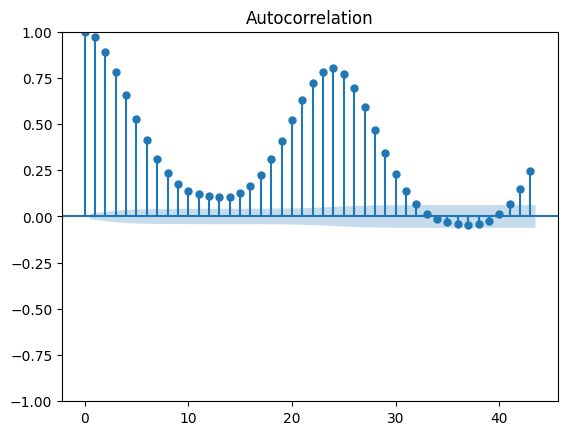

In [21]:
plot_acf(df['energy_demand'])
plt.show()

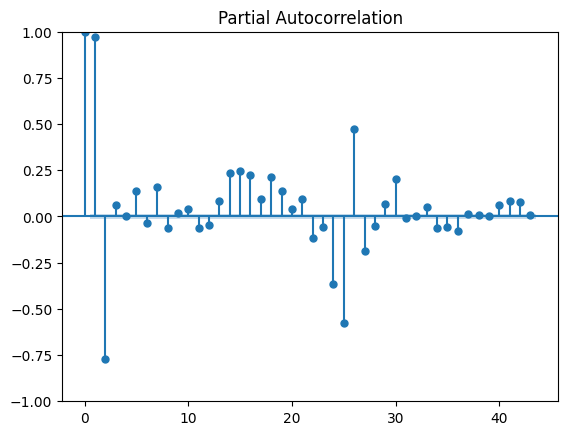

In [22]:
plot_pacf(df['energy_demand'])
plt.show()

In [89]:
df_sm = df.copy()
y = df_sm['energy_demand']
X = df_sm.copy()
X = X.drop(['energy_demand', 'date', 'is_weekend_False', 'atmospheric_pressure_sea_level', 'air_temp_dry_bulb', 'lag_1h', 'lag_6h',
       'lag_12h', 'lag_24h', 'lag_48h', 'lag_96h', 'lag_192h', 'lag_384h',
       'lag_744h'], axis = 1).astype(float)
metrics_sm = []
total_train_time = 0
total_inference_time = 0

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    start_train = time.time()
    model = SARIMAX(y_train, 
                    order=(2, 0, 1), 
                    seasonal_order=(1, 1, 1, 24), 
                    exog=X_train).fit()
    total_train_time += (time.time() - start_train)

    start_inference = time.time()
    y_pred = model.get_forecast(steps=len(X_test), exog=X_test).predicted_mean
    total_inference_time += (time.time() - start_inference)
    
    metrics_sm.append({
        'RMSE': root_mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred)
    })

df_sm = pd.DataFrame(metrics_sm).mean()
print(model.summary())
print(f"Tempo médio de treinamento: {total_train_time/10:.4f}s")
print(f"Tempo médio de inferencia: {total_inference_time/10:.4f}s")
df_sm

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

                                     SARIMAX Results                                      
Dep. Variable:                      energy_demand   No. Observations:                15950
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 24)   Log Likelihood             -127822.123
Date:                            Sat, 14 Feb 2026   AIC                         255674.247
Time:                                    19:21:54   BIC                         255789.382
Sample:                                         0   HQIC                        255712.335
                                          - 15950                                         
Covariance Type:                              opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
global_radiation         -0.1515      0.171     -0.886      0.375      -0.487       0.184
de

RMSE    3681.381231
MAE     2907.926287
MAPE       0.068851
dtype: float64